# Method of Simulated Moments (MSM) for Structural Estimation

### Steps of MSM estimation
1. Load empirical data
2. Define a function to calculate empirical moments from the data
3. Calculate the covariance matrix of the empirical moments (for the weighting matrix)
4. Define a `HARK` agent type with the model parameters to be estimated
5. Define a function to simulate the model and calculate the simulated moments
6. Estimate the model parameters by minimizing the distance between the empirical and simulated moments

In [1]:
from copy import copy

import estimagic as em
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

from HARK.Calibration.Income.IncomeTools import (
    Cagetti_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.Calibration.SCF.WealthIncomeDist.SCFDistTools import (
    get_scf_distr_stats,
    income_wealth_dists_from_scf,
)
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    init_lifecycle,
)
from HARK.estimation import estimate_msm
from HARK.utilities import plot_funcs

## 1. Load empirical data

In [2]:
scf_data = get_scf_distr_stats()
scf_data["Wealth"] = np.exp(scf_data["lnWealth.mean"])
scf_data = scf_data[scf_data["Educ"] == "College"]
scf_data = scf_data[scf_data["YEAR"] != "All"]
scf_data = scf_data[scf_data["Age_grp"] != "All"]
scf_data = scf_data[~scf_data["Age_grp"].isin(["(15,20]", "(20,25]"])]

scf_data

,Educ,YEAR,Age_grp,w.obs,obs,lnWealth.mean,lnWealth.sd,lnNrmWealth.mean,lnNrmWealth.sd,lnPermIncome.mean,lnPermIncome.sd,BASE_YR,Wealth
290,College,1995,"(25,30]",2.765032e+06,478.0,4.126304,1.270230,-0.091128,1.133600,4.217433,0.594117,2019,61.948554
291,College,1995,"(30,35]",2.819045e+06,553.0,4.485061,1.226898,0.142599,1.091322,4.342462,0.651507,2019,88.682362
292,College,1995,"(35,40]",2.516753e+06,666.0,4.817262,1.522302,0.337608,1.249328,4.479653,0.774831,2019,123.626079
293,College,1995,"(40,45]",3.582522e+06,1000.0,5.234296,1.587167,0.600269,1.340885,4.634028,0.670276,2019,187.597079
294,College,1995,"(45,50]",3.261238e+06,1114.0,5.712218,1.553071,0.890605,1.197825,4.821613,0.724982,2019,302.541454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,College,2019,"(70,75]",3.276375e+06,1058.0,6.618749,1.407732,2.126120,1.112098,4.492629,0.957018,2019,749.007589
428,College,2019,"(75,80]",1.836669e+06,543.0,6.392050,1.659717,2.061754,1.144179,4.330295,0.901808,2019,597.079225
429,College,2019,"(80,85]",1.195969e+06,352.0,6.233572,1.491591,1.943915,1.059349,4.289658,0.820112,2019,509.572465
430,College,2019,"(85,90]",6.284131e+05,129.0,6.010967,1.363456,1.792840,0.990714,4.218127,0.744886,2019,407.877637


## 2. Calculate Moments

In [3]:
indices = scf_data["Age_grp"].unique()


def calculate_weighted_median(data):
    stats = DescrStatsW(data["Wealth"], weights=data["w.obs"])
    return stats.quantile(0.5, return_pandas=False)[0]


def calculate_moments(data):
    medians = data.groupby(["Age_grp"]).apply(
        calculate_weighted_median,
        include_groups=False,
    )
    return medians.reindex(indices, fill_value=0.0)

In [4]:
empirical_moments = calculate_moments(scf_data)

<Axes: xlabel='Age_grp'>

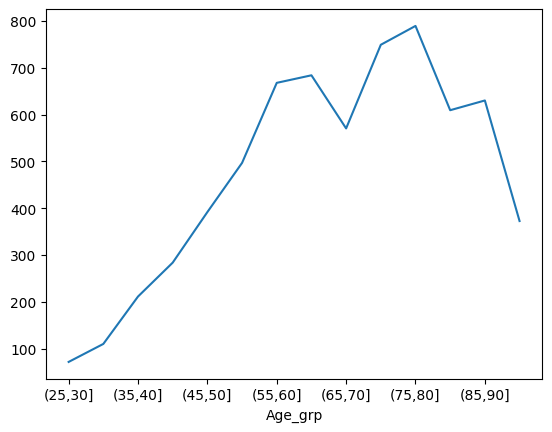

In [5]:
empirical_moments.plot()

## 3. Calculate the covariance matrix of empirical moments

In [6]:
moments_cov = em.get_moments_cov(
    scf_data,
    calculate_moments,
    bootstrap_kwargs={"n_draws": 5_000, "seed": 11323, "error_handling": "continue"},
)

moments_cov

Age_grp,"(25,30]","(30,35]","(35,40]","(40,45]","(45,50]","(50,55]","(55,60]","(60,65]","(65,70]","(70,75]","(75,80]","(80,85]","(85,90]","(90,95]"
Age_grp,,,,,,,,,,,,,,
"(25,30]",78.737485,-0.371681,-4.040328,-9.422402,13.093843,5.090706,1.389485,-5.709443,10.695572,6.195027,1.978852,-5.239811,-52.026812,13.828528
"(30,35]",-0.371681,111.941544,7.594072,2.187824,16.141333,-1.336970,5.330875,-5.597500,-0.134589,8.196271,19.774747,26.793106,37.315401,-42.416020
"(35,40]",-4.040328,7.594072,577.131713,-2.877333,37.316779,-0.267094,-4.269315,-10.520714,-56.049443,8.061753,-142.578652,5.639516,-34.492753,14.923283
"(40,45]",-9.422402,2.187824,-2.877333,1345.165864,9.970902,-24.375004,-12.797304,7.520201,-20.394739,26.082335,169.630000,12.434961,9.041112,39.198754
"(45,50]",13.093843,16.141333,37.316779,9.970902,2213.339739,-13.989562,-1.838498,31.312340,100.712927,-17.609319,17.421268,45.578331,52.952573,89.921968
"(50,55]",5.090706,-1.336970,-0.267094,-24.375004,-13.989562,1527.340485,14.733277,56.594261,32.309802,38.808547,-100.367914,-48.581634,42.225114,-7.900472
"(55,60]",1.389485,5.330875,-4.269315,-12.797304,-1.838498,14.733277,1708.687643,37.805573,-27.926395,-9.556498,75.322901,84.918302,-39.100823,-11.622967
"(60,65]",-5.709443,-5.597500,-10.520714,7.520201,31.312340,56.594261,37.805573,3267.096856,-101.175101,1.004139,-27.080202,20.062823,118.732200,-143.400780
"(65,70]",10.695572,-0.134589,-56.049443,-20.394739,100.712927,32.309802,-27.926395,-101.175101,13000.202130,-16.414305,-310.214803,95.090219,838.940789,-446.093482


## 4. Define an agent type to simulate data

In [16]:
birth_age = 25
death_age = 100
adjust_infl_to = 1992
income_calib = Cagetti_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params["LivPrb"] = liv_prb
params["AgentCount"] = 10_000
params["T_sim"] = 200
params["track_vars"] = ["aNrm", "bNrm", "cNrm", "pLvl", "t_age", "mNrm"]
params["PermGroFacAgg"] = 1.0
params["Rfree"] = [params["Rfree"][0]] * params["T_cycle"]

In [17]:
LifeCycleAgent = IndShockConsumerType(**params)
LifeCycleAgent.solve()

Consumption functions


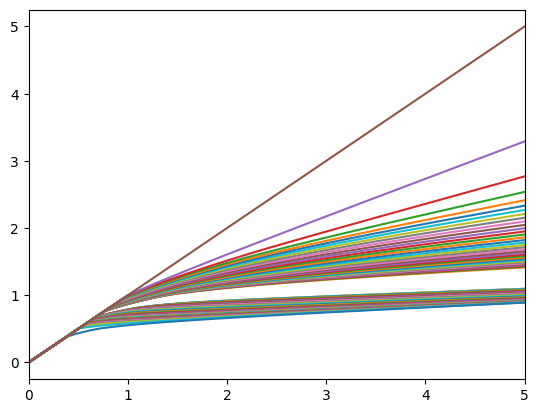

In [18]:
LifeCycleAgent.unpack("cFunc")
# Plot the consumption functions
print("Consumption functions")
plot_funcs(LifeCycleAgent.cFunc, 0, 5)

In [19]:
LifeCycleAgent.update()

# Run the simulations
LifeCycleAgent.initialize_sim()
history = LifeCycleAgent.simulate()

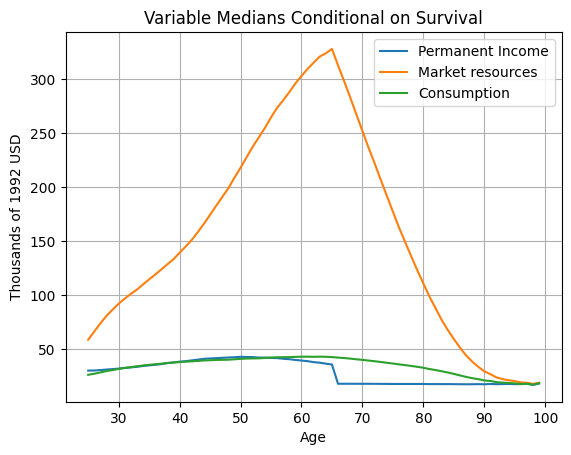

In [20]:
raw_data = {
    "Age": history["t_age"].flatten() + birth_age - 1,
    "pIncome": history["pLvl"].flatten(),
    "nrmM": history["mNrm"].flatten(),
    "nrmC": history["cNrm"].flatten(),
}

sim_data = pd.DataFrame(raw_data)
sim_data["Cons"] = sim_data.nrmC * sim_data.pIncome
sim_data["M"] = sim_data.nrmM * sim_data.pIncome

# Find the mean of each variable at every age
AgeMeans = sim_data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

In [21]:
age_groups = [
    list(range(start, start + 5)) for start in range(birth_age + 1, 95 + 1, 5)
]

# generate labels as (25,30], (30,35], ...
age_labels = [f"({group[0]-1},{group[-1]}]" for group in age_groups]

# Generate mappings between the real ages in the groups and the indices of simulated data
age_mapping = dict(zip(age_labels, map(np.array, age_groups)))

In [22]:
age_mapping

{'(25,30]': array([26, 27, 28, 29, 30]),
 '(30,35]': array([31, 32, 33, 34, 35]),
 '(35,40]': array([36, 37, 38, 39, 40]),
 '(40,45]': array([41, 42, 43, 44, 45]),
 '(45,50]': array([46, 47, 48, 49, 50]),
 '(50,55]': array([51, 52, 53, 54, 55]),
 '(55,60]': array([56, 57, 58, 59, 60]),
 '(60,65]': array([61, 62, 63, 64, 65]),
 '(65,70]': array([66, 67, 68, 69, 70]),
 '(70,75]': array([71, 72, 73, 74, 75]),
 '(75,80]': array([76, 77, 78, 79, 80]),
 '(80,85]': array([81, 82, 83, 84, 85]),
 '(85,90]': array([86, 87, 88, 89, 90]),
 '(90,95]': array([91, 92, 93, 94, 95])}

## 5. Define a function to calculate simulated moments

In [23]:
def simulate_moments(params, agent=None):
    agent.assign_parameters(**params)
    agent.update()

    agent.solve()

    agent.initialize_sim()
    history = agent.simulate()

    raw_data = {
        "age": history["t_age"].flatten() + birth_age - 1,
        "b_nrm": history["bNrm"].flatten(),
        "p_lvl": history["pLvl"].flatten(),
    }

    sim_data = pd.DataFrame(raw_data)
    sim_data["Wealth"] = sim_data.b_nrm * sim_data.p_lvl

    sim_data["Age_grp"] = pd.cut(
        sim_data.age,
        bins=range(birth_age + 1, 97, 5),
        labels=age_labels,
        right=False,
    )

    sim_data = sim_data.dropna()

    return sim_data.groupby("Age_grp", observed=False)["Wealth"].median()

<Axes: xlabel='Age_grp'>

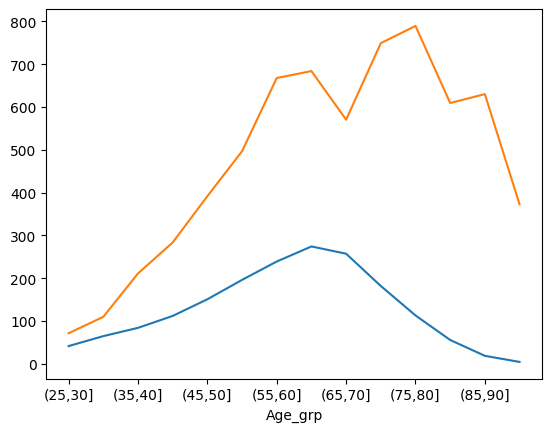

In [24]:
simulate_moments({}, agent=LifeCycleAgent).plot()
empirical_moments.plot()

## 6. Estimate the model parameters

In [25]:
init_params = {"CRRA": 3.009252, "DiscFac": 1.006925}
lower_bounds = {"CRRA": 1.0, "DiscFac": 0.9}
upper_bounds = {"CRRA": 10.0, "DiscFac": 1.1}

res = estimate_msm(
    LifeCycleAgent,
    init_params,
    empirical_moments,
    moments_cov,
    simulate_moments,
    optimize_options={
        "algorithm": "scipy_lbfgsb",
        "error_handling": "continue",
    },
    estimagic_options={
        "lower_bounds": lower_bounds,
        "upper_bounds": upper_bounds,
    },
)

C:\Users\Matthew\Anaconda3\envs\HARKlatest\lib\site-packages\optimagic\deprecations.py:247: FutureWarning: Specifying bounds via the arguments lower_bound, and upper_bound is deprecated and will be removed in optimagic version 0.6.0 and later. Please use the `bounds` argument instead.
  warnings.warn(msg, FutureWarning)


In [26]:
pd.concat(res.summary())

,,value,standard_error,ci_lower,ci_upper,p_value,free,stars
CRRA,0,3.009267,1.093115,0.866801,5.151733,0.005906,True,***
DiscFac,0,1.006906,0.003080,1.000870,1.012943,0.000000,True,***


In [27]:
res.params

{'CRRA': 3.0092673270454973, 'DiscFac': 1.0069061115416176}

In [28]:
pd.DataFrame(res.cov(method="robust"))

,CRRA,DiscFac
CRRA,1.1949005058205033,-0.0014946240256966856
DiscFac,-0.0014946240256966839,9.486071180118776e-06


In [29]:
res.se()

{'CRRA': 1.0931150469280455, 'DiscFac': 0.0030799466196865777}

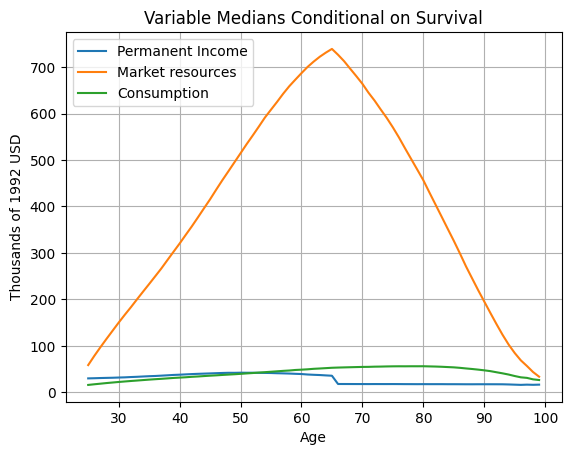

In [30]:
LifeCycleAgent.assign_parameters(**res.params)
LifeCycleAgent.update()
LifeCycleAgent.solve()
LifeCycleAgent.initialize_sim()
history = LifeCycleAgent.simulate()

raw_data = {
    "Age": history["t_age"].flatten() + birth_age - 1,
    "pIncome": history["pLvl"].flatten(),
    "nrmM": history["mNrm"].flatten(),
    "nrmC": history["cNrm"].flatten(),
}

sim_data = pd.DataFrame(raw_data)
sim_data["Cons"] = sim_data.nrmC * sim_data.pIncome
sim_data["M"] = sim_data.nrmM * sim_data.pIncome

# Find the mean of each variable at every age
AgeMeans = sim_data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

<Axes: xlabel='Age_grp'>

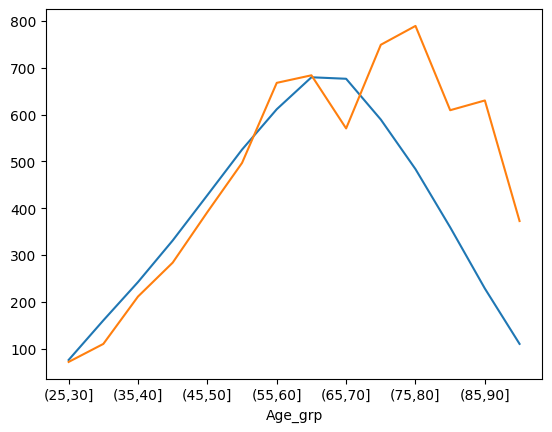

In [31]:
simulate_moments(res.params, agent=LifeCycleAgent).plot()
empirical_moments.plot()